### Подключим необходимые библиотеки

In [2]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm, wbysqdist
from reskit.norms import spectral_norm

#from reskit.features import degrees,  pagerank

from reskit.core import Transformer, Pipeliner

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier 
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import os
import pandas as pd
import numpy as np

import matrix_eig as me

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

### Функция считывания данных

In [3]:
def get_autism(path_to_read='../Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict


## Обучим SVM

In [4]:
#Функция понижения размерности 
def matrix_eig(data, k = 250):
    new_data = {}
    new_data['y'] = data['y']
    new_data['X'] = np.zeros(shape = (data['X'].shape[0], data['X'].shape[1], data['X'].shape[1] - k))
    for i in np.arange(data['X'].shape[0]):
        curs, vecs = np.linalg.eig(data['X'][i])
        indeces_del = curs.argsort()[:k]
        vecs_n = np.delete(vecs, indeces_del, axis=1)
        curs = np.delete(curs, indeces_del)
        new_data['X'][i] = vecs_n.dot(np.diag(curs)).astype('float')
    return orig_vec(new_data)

#Функция, которая в словаре data из матриц X создает вектора X_vec
def orig_vec(data):
    matrix = []
    for i in  data['X']:
        matrix.append(np.hstack(i))
    data['X_vec'] = matrix
    return data

#Функция преобразования матрицы в вектор и наоборот
def convert(A, mode, size = 264):
    if mode == 'mat2vec':
        A_vec = np.hstack(A)
        return A_vec
        
    if mode == 'vec2mat':
        A_mat = []
        i = 0
        while i != A.shape[0]:
            A_str = A[0+i:size+i]
            A_mat.append(A_str)
            i += size
        A_mat = np.vstack(A_mat)
        return A_mat

In [10]:
#Ядро
from math import exp

def ker(A, B):
    #Данные подавются в виде векторов, поэтому преобразуем их в матрицы
    A = convert(A, 'vec2mat')
    B = convert(B, 'vec2mat')
    #Посчитаем расстояние
    d = np.linalg.norm(A.dot(A.T) - B.dot(B.T), 'fro')
    return exp(-d * 10**-6)

def my_kernel(X, Xfit):
    size1 = np.shape(X)[0]
    size2 = np.shape(Xfit)[0]
    dist = np.zeros([size1, size2])
    for i in range(size1):
        for j in range(size2):
            dist[i][j] = ker(X[i], Xfit[j])
    return dist

### Посмотрим на корреляцию объектов

In [119]:
from matplotlib import pyplot as plt
%matplotlib inline

def print_ker(ker, color):
    y_ker = np.hstack(ker)
    x_ker = np.arange(y_ker.shape[0])
    plt.plot(x_ker, y_ker, color)
    
def meaning(ker):
    if ker.shape[0] == ker.shape[1]:
        rows, cols = np.triu_indices(ker.shape[0],k = 0)
        y_ker = ker[rows,cols]
    else:
        y_ker = np.hstack(ker)
    return y_ker
    
def print_kers(kers):
    f1, ax1 = plt.subplots(1, np.size(kers), sharey=True, figsize=(21, 5))
    f2, ax2 = plt.subplots(1, np.size(kers), sharey=True, figsize=(21, 5))
    for (i,ker) in enumerate(kers):
        y_ker = meaning(ker)
        x_ker = np.arange(y_ker.shape[0])
        ax2[i].plot(x_ker, y_ker,'bo')
        ax1[i].hist(y_ker)

In [85]:
def show_ker(k):
    data = matrix_eig(get_autism("../Data/dti/"), k=k)
    X = data['X_vec']
    y = data['y']

    X_0 = []
    X_1 = []
    for (i, y_i) in enumerate(y):
        if   y_i == 0: X_0.append(X[i])
        elif y_i == 1: X_1.append(X[i])
            
    ker_1_1 = my_kernel(X_1, X_1)
    ker_0_0 = my_kernel(X_0, X_0)
    ker_0_1 = my_kernel(X_0, X_1)
    
    print_kers([ker_0_0, ker_0_1, ker_1_1])

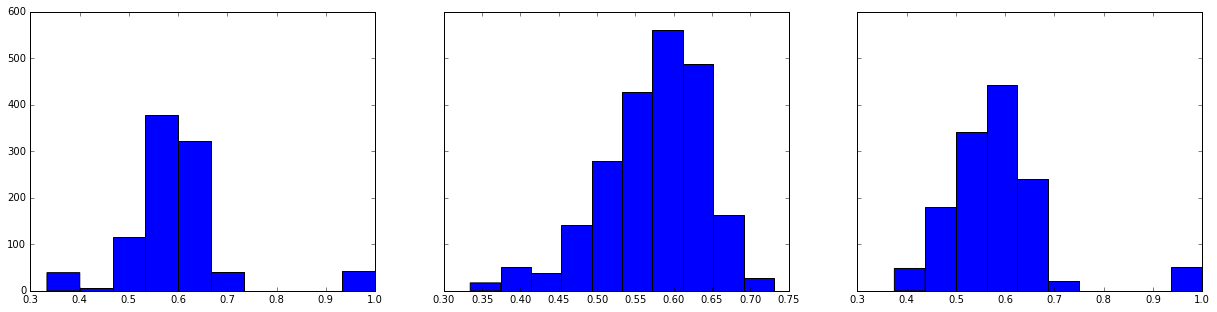

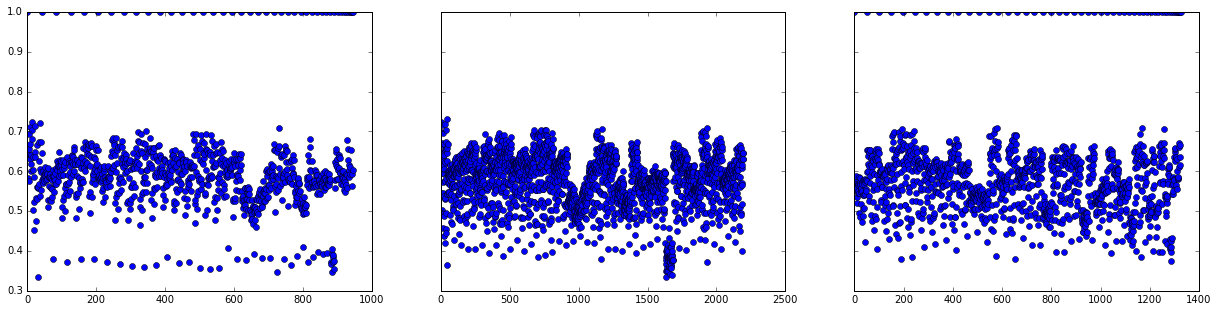

In [129]:
show_ker(200)

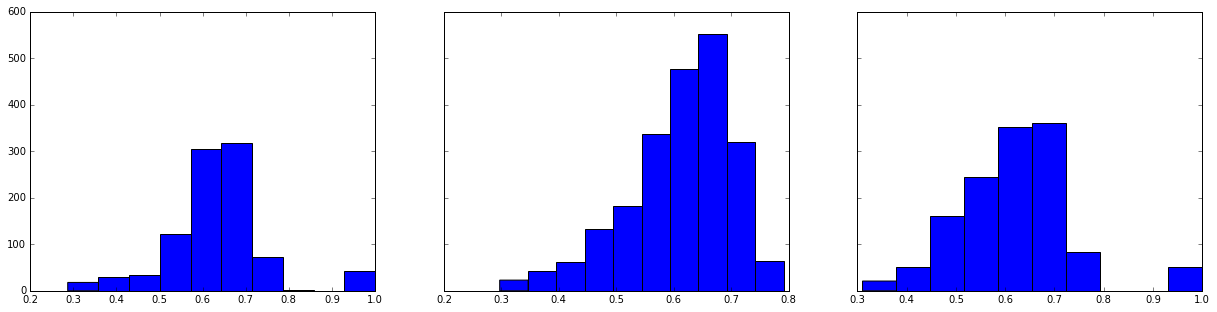

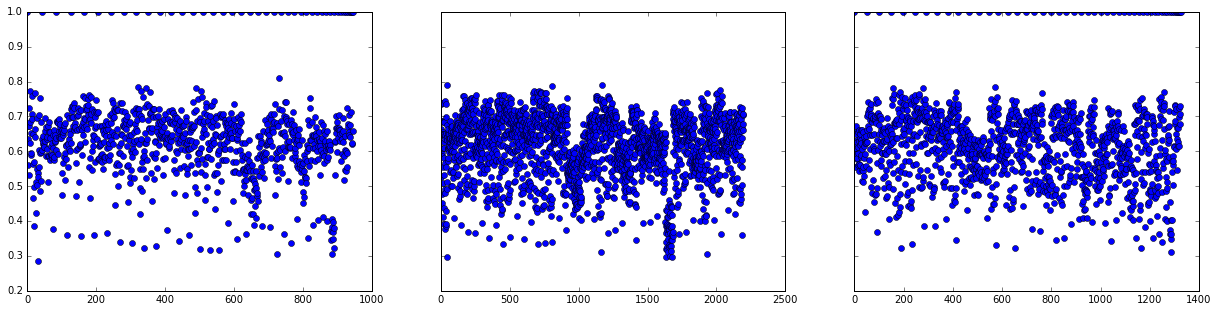

In [128]:
show_ker(220)

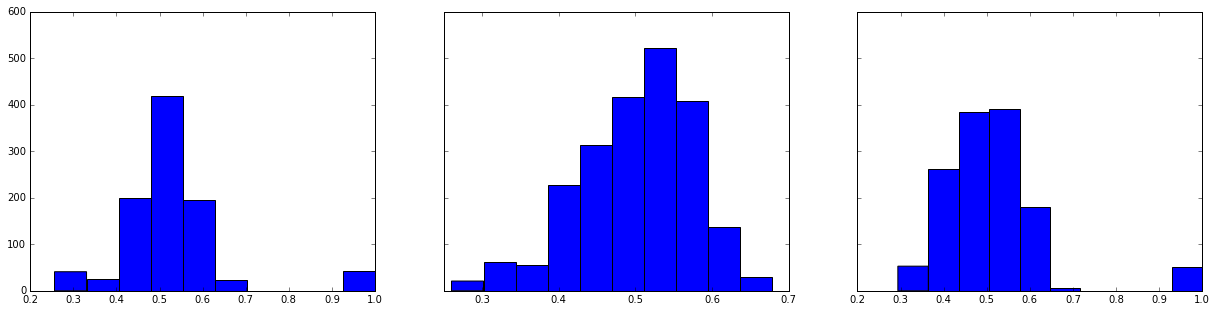

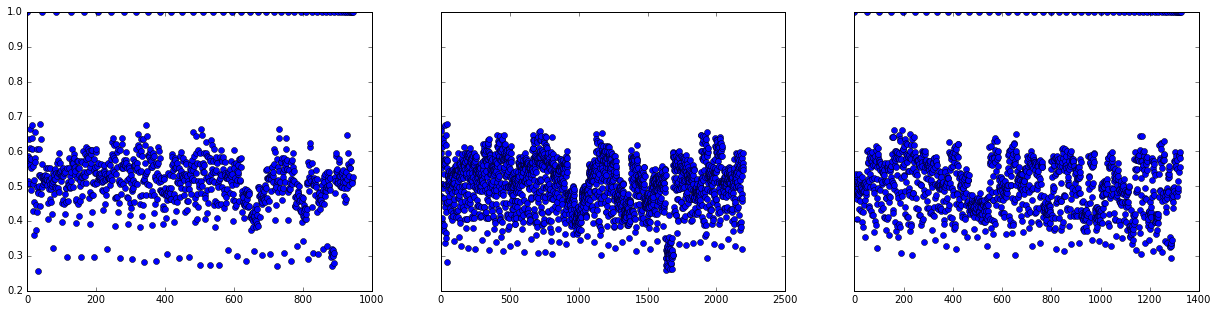

In [120]:
show_ker(230)

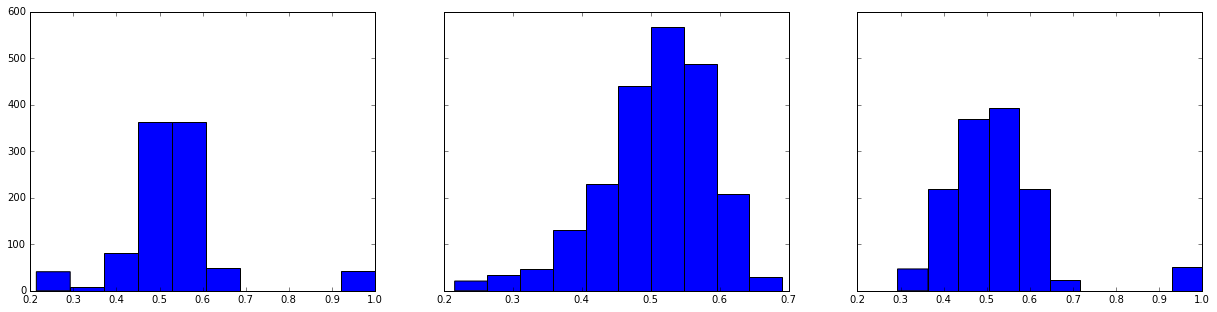

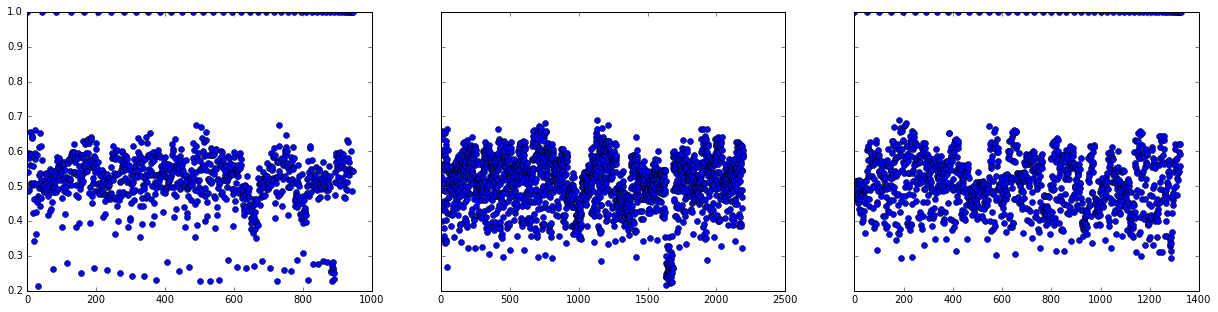

In [121]:
show_ker(245)

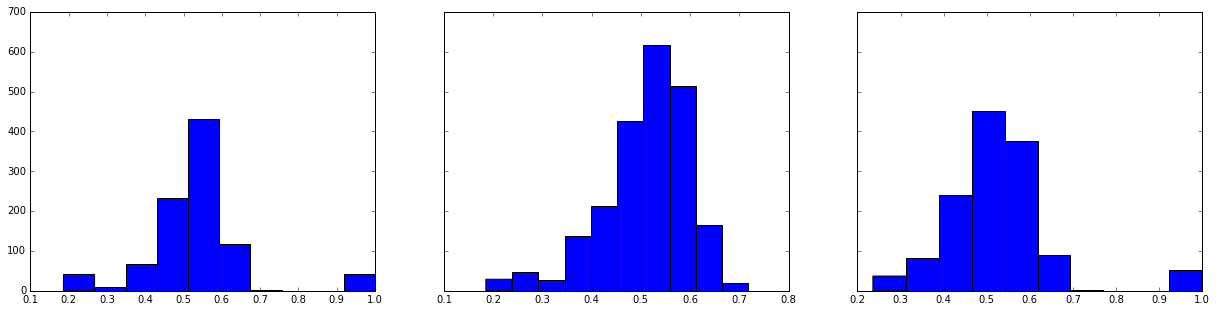

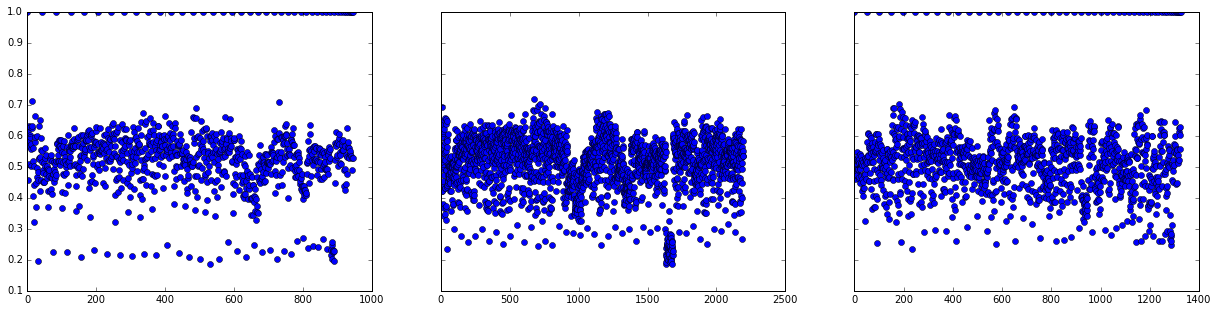

In [122]:
show_ker(250)

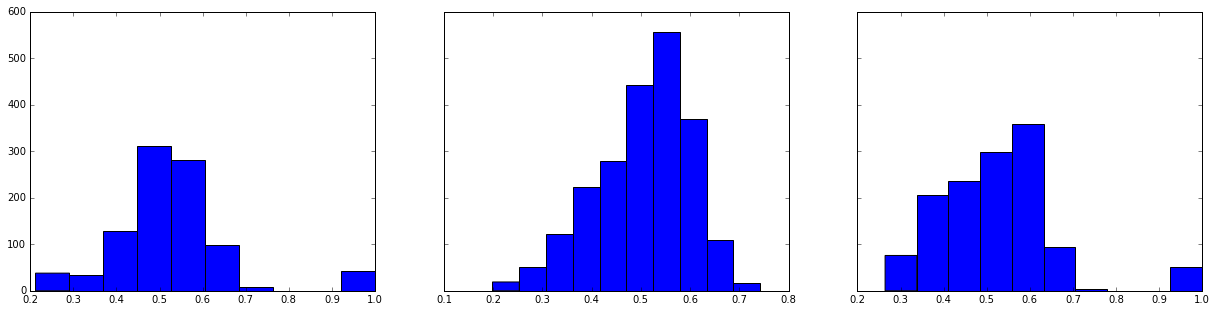

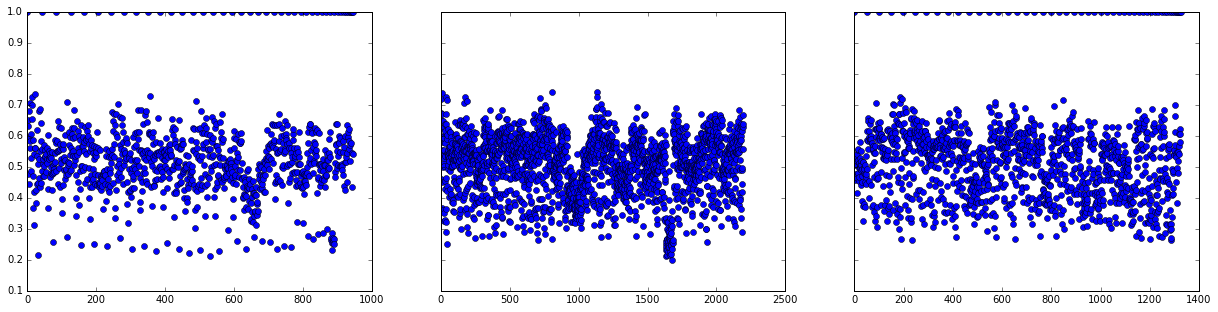

In [123]:
show_ker(255)

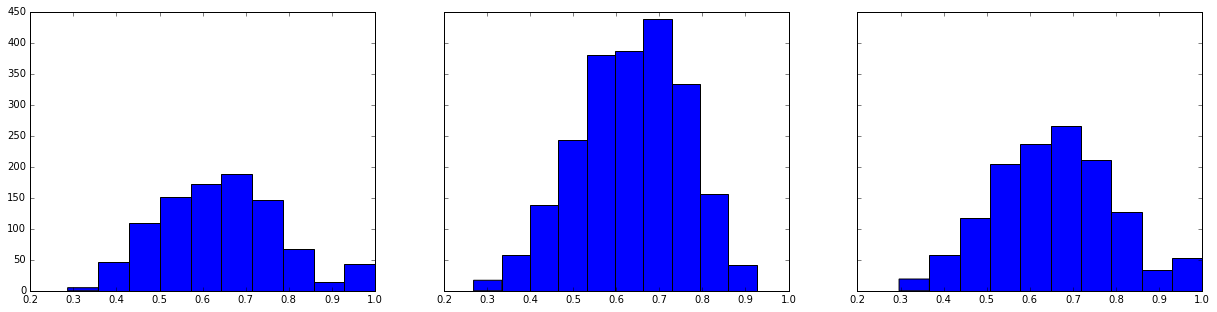

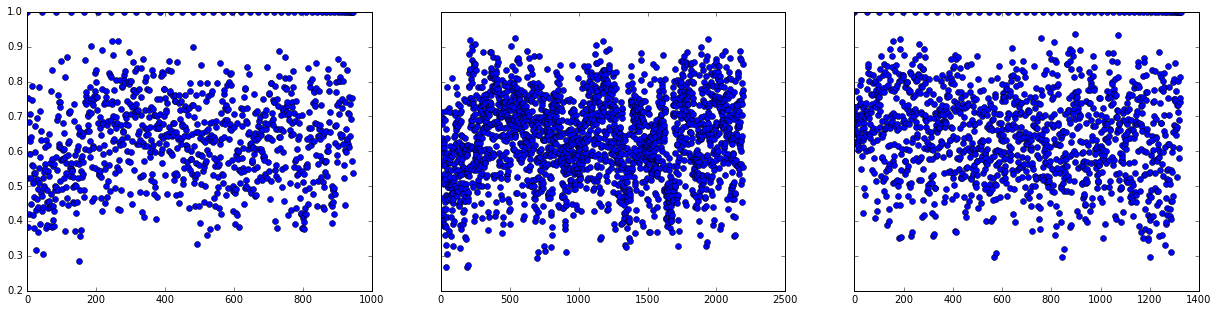

In [124]:
show_ker(260)

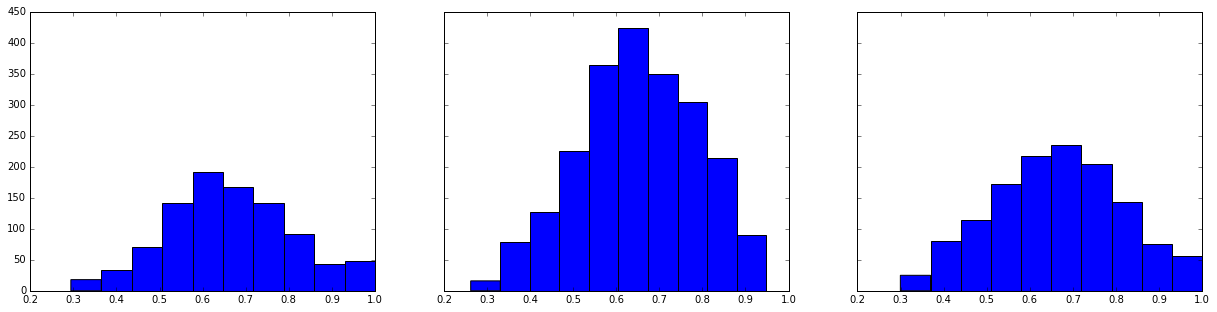

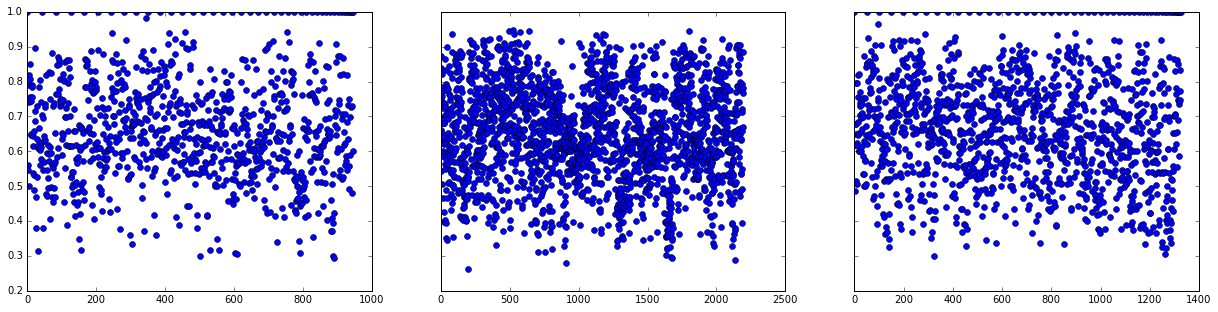

In [125]:
show_ker(261)

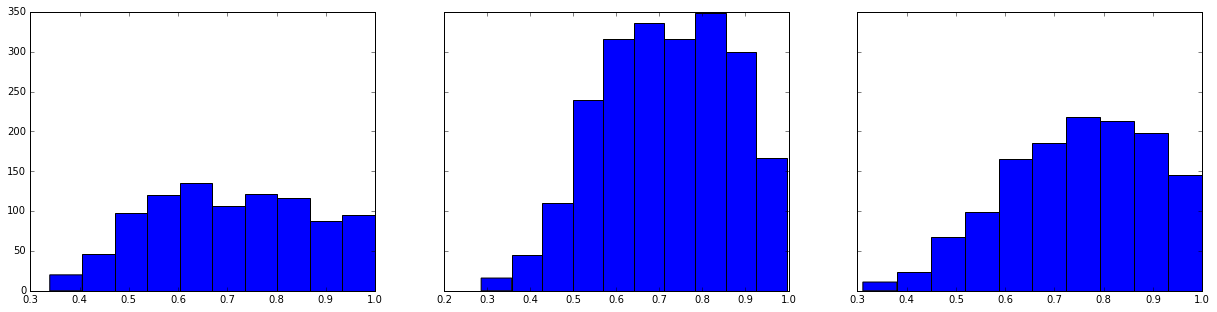

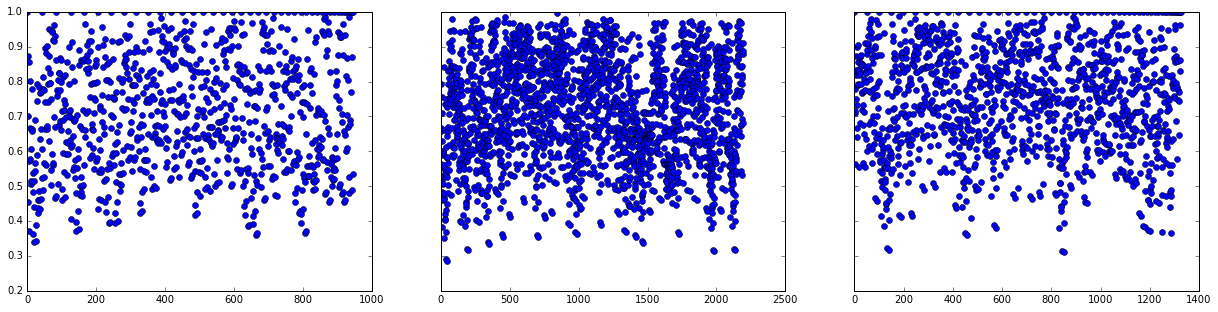

In [126]:
show_ker(262)

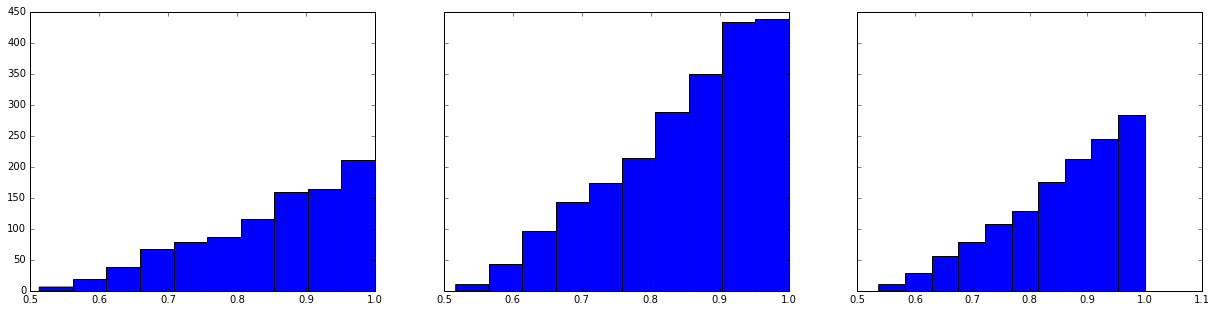

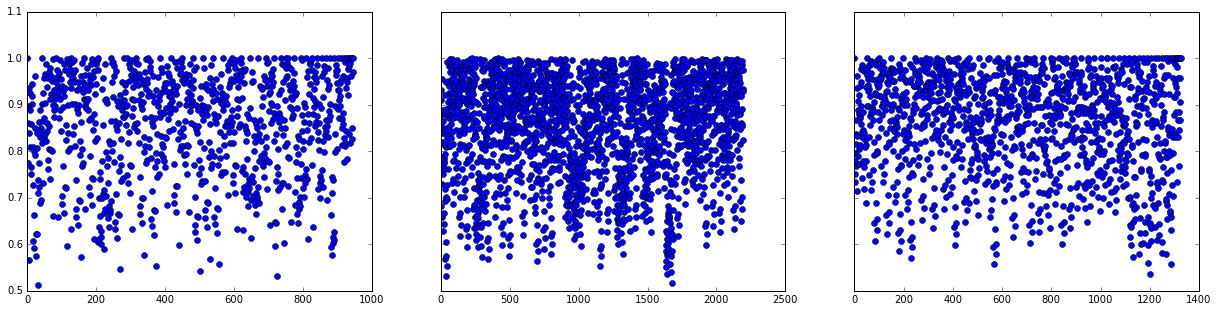

In [127]:
show_ker(263)

### Обычным способом

In [18]:
data = matrix_eig(get_autism("../Data/dti/"), k=250)
X = data['X_vec']
y = data['y']

In [40]:
from sklearn import cross_validation

In [157]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.1)

In [171]:
clf = SVC(kernel=my_kernel, C=1)
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto',
  kernel=<function my_kernel at 0x7f826ce5b050>, max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

In [170]:
print clf.predict(X_test)
print y_test

[1 1 1 1 1 1 1 1 1 1]
[0 1 0 1 0 0 0 1 1 1]


In [137]:
clf.score(X_test, y_test)

0.66666666666666663

In [124]:
import sklearn.metrics as metrics
metrics.roc_auc_score(y_test, clf.predict(X_test))

0.5

### Используя класс Papiliner

In [37]:
grid_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=0)

eval_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=1)

data =          [('UCLAsource', Transformer(get_autism))]

weighters =     [('origW', Transformer(orig)),
                #('binar', Transformer(binar_norm))
                ]


normalizers =   [('origN', Transformer(orig)),
                #('spectral', Transformer(spectral_norm))
                ]

featurizers =   [#('origF', Transformer(orig_vec, collect=['X_vec'])),
                 ('low_rank_245', Transformer(me.matrix_eig_245, collect=['X_vec'])),
                 ('low_rank_250', Transformer(me.matrix_eig_250, collect=['X_vec'])),
                 ('low_rank_255', Transformer(me.matrix_eig_255, collect=['X_vec'])),
                 ('low_rank_260', Transformer(me.matrix_eig_260, collect=['X_vec']))
                ]

selectors =     [('var_threshold', VarianceThreshold())]

scalers =       [('minmax', MinMaxScaler()),
                  ('origS', FunctionTransformer(orig))
                ]


classifiers =   [('SVC', SVC())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

banned_combos = [
                 #('SVC', 'origS'),
                 ('SVC', 'minmax'),
                 ]

param_grid = dict(
    SVC=dict(
        C=[1.0],
        kernel=[my_kernel]
    )
)

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,origW,origN,low_rank_245,var_threshold,origS,SVC
1,UCLAsource,origW,origN,low_rank_250,var_threshold,origS,SVC
2,UCLAsource,origW,origN,low_rank_255,var_threshold,origS,SVC
3,UCLAsource,origW,origN,low_rank_260,var_threshold,origS,SVC


In [38]:
result = pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'], scoring=['roc_auc'])

Removed previous results file -- results.csv.
Line: 1/4
Line: 2/4
Line: 3/4
Line: 4/4


In [39]:
result

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,origW,origN,low_rank_245,var_threshold,origS,SVC,0.38883,0.195855,{'kernel': <function my_kernel at 0x7f826f8904...,0.382667,0.169344,[ 0.26666667 0.24 0.32 0.45 ...
1,UCLAsource,origW,origN,low_rank_250,var_threshold,origS,SVC,0.278723,0.162737,{'kernel': <function my_kernel at 0x7f826f8904...,0.31,0.131909,[ 0.4 0.2 0.2 0.25 0.3 0.1 0.55 0....
2,UCLAsource,origW,origN,low_rank_255,var_threshold,origS,SVC,0.476064,0.227466,{'kernel': <function my_kernel at 0x7f826f8904...,0.450333,0.191262,[ 0.33333333 0.16 0.36 0.55 ...
3,UCLAsource,origW,origN,low_rank_260,var_threshold,origS,SVC,0.432624,0.192837,{'kernel': <function my_kernel at 0x7f826f8904...,0.507667,0.231291,[ 0.56666667 0.56 0.2 0.75 ...
